#### Učitavanje baze i pretprocesiranje

In [28]:
import collections
import flair.datasets
from flair.data import Sentence, Dictionary
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings
from flair.models import SequenceTagger, LanguageModel
from flair.trainers import ModelTrainer, LanguageModelTrainer, TextCorpus
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [35]:
is_forward_lm = True
dictionary: Dictionary = Dictionary.load('chars-xl')

# get your corpus, process forward and at the character level
corpus = TextCorpus('corpus',
                    dictionary,
                    is_forward_lm,
                    character_level=True)

# instantiate your language model, set hidden size and number of layers
language_model = LanguageModel(dictionary,
                               is_forward_lm,
                               hidden_size=128,
                               nlayers=1)
trainer = LanguageModelTrainer(language_model, corpus)

trainer.train('resources/taggers/language_model',
              sequence_length=10,
              mini_batch_size=10,
              max_epochs=10)

2022-08-27 23:21:34,609 read text file with 8 lines
2022-08-27 23:21:34,615 read text file with 8 lines
2022-08-27 23:21:38,493 Sequence length is 10
2022-08-27 23:21:38,494 Split 1	 - (23:21:38)
2022-08-27 23:21:41,271 | split   1/  2 |   100/  130 batches | ms/batch 27.76 | loss 4.0250 | ppl 55.9811
2022-08-27 23:21:43,379 best split so far
2022-08-27 23:21:43,380 best loss so far 3.08945566
2022-08-27 23:21:44,159 ('\n  ni spoku.   s 龛i smoon祇錨u  ko mel,寥 . po  o팰ậalrišj bel de 毯 kilile o  iš<unk>pi r svžlitl捜ačio์ulibite.  pe svi bos rila bijƗ糗嶽n,  迁nsposmu pe 鐙om preoge,  se v肤rn . pre madn bidije  di piveš dešle应lise  pelešomo秆j  pile ˊ.      ri pi dli smeba  šnda , 蝗o dovi cek. ഔ  zo  spepra   pi vure dikig錬o d iol, o niko mibi  plobuc dočre  ilile pić lrigatri 습 狙or. o怅at漱ški zi  liš smoco   nela so peri bi čer k곗目e pr厨ige ći 르 vel층 锦Tolš , sa  gi eglekalte rjdooćaj   l젖ličej   s sla  s, pe ple rj ti  i di  s ce estj o liši, lu   pro. bre.  mra jodire   pre onmj cioko២e  s 煆e  

In [40]:
sentence = Sentence('Ja volim Beograd.')

# init embeddings from your trained LM
char_lm_embeddings = FlairEmbeddings('resources/taggers/language_model/best-lm.pt')

# embed sentence
char_lm_embeddings.embed(sentence)

KeyboardInterrupt: 

In [31]:
tagger = SequenceTagger(hidden_size=256,
                        embeddings=char_lm_embeddings,
                        tag_dictionary=dictionary,
                        tag_type='upos',
                        use_crf=True)

trainer = ModelTrainer(tagger, corpus)

2022-08-27 23:18:03,708 SequenceTagger predicts: Dictionary with 11854 tags: <unk>,  , a, e, i, n, o, t, s, l, r, u, m, k, d, g, h, b, 
, p, ​, y, ., v, ,, w, c, f, z, j, а, о, и, е, н, т, р, 1, α, с, :, л, д, ο, A, в, ’, τ, ä, é


In [93]:
trainer.train('resources/taggers/example-upos',
              learning_rate=0.1,
              mini_batch_size=1000,
              max_epochs=20)

2022-08-27 19:18:08,406 ----------------------------------------------------------------------------------------------------
2022-08-27 19:18:08,407 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=4196, out_features=4196, b

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-08-27 19:18:18,651 epoch 1 - iter 1/1 - loss 1.27106609 - samples/sec: 97.72 - lr: 0.100000
2022-08-27 19:18:18,652 ----------------------------------------------------------------------------------------------------
2022-08-27 19:18:18,653 EPOCH 1 done: loss 1.2711 - lr 0.100000


100%|██████████| 1/1 [00:08<00:00,  8.37s/it]

2022-08-27 19:18:27,032 Evaluating as a multi-label problem: False
2022-08-27 19:18:27,041 DEV : loss 0.6735531687736511 - f1-score (micro avg)  0.7323
2022-08-27 19:18:27,047 BAD EPOCHS (no improvement): 0
2022-08-27 19:18:27,048 saving best model


2022-08-27 19:18:28,335 ----------------------------------------------------------------------------------------------------
2022-08-27 19:18:38,298 epoch 2 - iter 1/1 - loss 1.34105995 - samples/sec: 100.39 - lr: 0.100000
2022-08-27 19:18:38,299 ----------------------------------------------------------------------------------------------------
2022-08-27 19:18:38,299 EPOCH 2 done: loss 1.3411 - lr 0.100000


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

2022-08-27 19:18:38,994 Evaluating as a multi-label problem: False
2022-08-27 19:18:39,003 DEV : loss 0.5619812607765198 - f1-score (micro avg)  0.8962
2022-08-27 19:18:39,009 BAD EPOCHS (no improvement): 0
2022-08-27 19:18:39,010 saving best model


2022-08-27 19:18:40,243 ----------------------------------------------------------------------------------------------------
2022-08-27 19:18:50,441 epoch 3 - iter 1/1 - loss 1.25373457 - samples/sec: 98.08 - lr: 0.100000
2022-08-27 19:18:50,442 ----------------------------------------------------------------------------------------------------
2022-08-27 19:18:50,443 EPOCH 3 done: loss 1.2537 - lr 0.100000


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

2022-08-27 19:18:51,115 Evaluating as a multi-label problem: False
2022-08-27 19:18:51,125 DEV : loss 0.62995845079422 - f1-score (micro avg)  0.7361
2022-08-27 19:18:51,129 BAD EPOCHS (no improvement): 1
2022-08-27 19:18:51,130 ----------------------------------------------------------------------------------------------------


2022-08-27 19:19:01,191 epoch 4 - iter 1/1 - loss 1.27344539 - samples/sec: 99.41 - lr: 0.100000
2022-08-27 19:19:01,192 ----------------------------------------------------------------------------------------------------
2022-08-27 19:19:01,193 EPOCH 4 done: loss 1.2734 - lr 0.100000


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

2022-08-27 19:19:01,874 Evaluating as a multi-label problem: False
2022-08-27 19:19:01,883 DEV : loss 0.6405262351036072 - f1-score (micro avg)  0.7977
2022-08-27 19:19:01,887 BAD EPOCHS (no improvement): 2
2022-08-27 19:19:01,888 ----------------------------------------------------------------------------------------------------


2022-08-27 19:19:12,137 epoch 5 - iter 1/1 - loss 1.25607023 - samples/sec: 97.58 - lr: 0.100000
2022-08-27 19:19:12,138 ----------------------------------------------------------------------------------------------------
2022-08-27 19:19:12,138 EPOCH 5 done: loss 1.2561 - lr 0.100000


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

2022-08-27 19:19:12,859 Evaluating as a multi-label problem: False
2022-08-27 19:19:12,870 DEV : loss 0.5417186617851257 - f1-score (micro avg)  0.8376
2022-08-27 19:19:12,875 BAD EPOCHS (no improvement): 3
2022-08-27 19:19:12,876 ----------------------------------------------------------------------------------------------------


2022-08-27 19:19:22,698 epoch 6 - iter 1/1 - loss 1.28794042 - samples/sec: 101.82 - lr: 0.100000
2022-08-27 19:19:22,699 ----------------------------------------------------------------------------------------------------
2022-08-27 19:19:22,699 EPOCH 6 done: loss 1.2879 - lr 0.100000


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

2022-08-27 19:19:23,367 Evaluating as a multi-label problem: False
2022-08-27 19:19:23,379 DEV : loss 0.7212200164794922 - f1-score (micro avg)  0.7586
2022-08-27 19:19:23,384 Epoch     6: reducing learning rate of group 0 to 5.0000e-02.
2022-08-27 19:19:23,385 BAD EPOCHS (no improvement): 4
2022-08-27 19:19:23,386 ----------------------------------------------------------------------------------------------------


2022-08-27 19:19:33,321 epoch 7 - iter 1/1 - loss 1.24420609 - samples/sec: 100.66 - lr: 0.050000
2022-08-27 19:19:33,322 ----------------------------------------------------------------------------------------------------
2022-08-27 19:19:33,323 EPOCH 7 done: loss 1.2442 - lr 0.050000


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

2022-08-27 19:19:34,009 Evaluating as a multi-label problem: False
2022-08-27 19:19:34,019 DEV : loss 0.5255580544471741 - f1-score (micro avg)  0.8955
2022-08-27 19:19:34,026 BAD EPOCHS (no improvement): 1
2022-08-27 19:19:34,026 ----------------------------------------------------------------------------------------------------


2022-08-27 19:19:43,841 epoch 8 - iter 1/1 - loss 1.16348858 - samples/sec: 101.91 - lr: 0.050000
2022-08-27 19:19:43,843 ----------------------------------------------------------------------------------------------------
2022-08-27 19:19:43,843 EPOCH 8 done: loss 1.1635 - lr 0.050000


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

2022-08-27 19:19:44,517 Evaluating as a multi-label problem: False
2022-08-27 19:19:44,526 DEV : loss 0.5499294996261597 - f1-score (micro avg)  0.8263
2022-08-27 19:19:44,532 BAD EPOCHS (no improvement): 2
2022-08-27 19:19:44,533 ----------------------------------------------------------------------------------------------------


2022-08-27 19:19:54,578 epoch 9 - iter 1/1 - loss 1.15925080 - samples/sec: 99.56 - lr: 0.050000
2022-08-27 19:19:54,579 ----------------------------------------------------------------------------------------------------
2022-08-27 19:19:54,580 EPOCH 9 done: loss 1.1593 - lr 0.050000


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

2022-08-27 19:19:55,244 Evaluating as a multi-label problem: False
2022-08-27 19:19:55,252 DEV : loss 0.5973075032234192 - f1-score (micro avg)  0.8135
2022-08-27 19:19:55,257 BAD EPOCHS (no improvement): 3
2022-08-27 19:19:55,258 ----------------------------------------------------------------------------------------------------


2022-08-27 19:20:05,199 epoch 10 - iter 1/1 - loss 1.17527963 - samples/sec: 100.60 - lr: 0.050000
2022-08-27 19:20:05,200 ----------------------------------------------------------------------------------------------------
2022-08-27 19:20:05,200 EPOCH 10 done: loss 1.1753 - lr 0.050000


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

2022-08-27 19:20:05,894 Evaluating as a multi-label problem: False
2022-08-27 19:20:05,903 DEV : loss 0.50634765625 - f1-score (micro avg)  0.8451
2022-08-27 19:20:05,908 Epoch    10: reducing learning rate of group 0 to 2.5000e-02.
2022-08-27 19:20:05,909 BAD EPOCHS (no improvement): 4
2022-08-27 19:20:05,910 ----------------------------------------------------------------------------------------------------


2022-08-27 19:20:16,057 epoch 11 - iter 1/1 - loss 1.14633031 - samples/sec: 98.56 - lr: 0.025000
2022-08-27 19:20:16,058 ----------------------------------------------------------------------------------------------------
2022-08-27 19:20:16,059 EPOCH 11 done: loss 1.1463 - lr 0.025000


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

2022-08-27 19:20:16,755 Evaluating as a multi-label problem: False
2022-08-27 19:20:16,764 DEV : loss 0.5359367728233337 - f1-score (micro avg)  0.8519
2022-08-27 19:20:16,770 BAD EPOCHS (no improvement): 1
2022-08-27 19:20:16,771 ----------------------------------------------------------------------------------------------------


2022-08-27 19:20:26,865 epoch 12 - iter 1/1 - loss 1.13216181 - samples/sec: 99.08 - lr: 0.025000
2022-08-27 19:20:26,866 ----------------------------------------------------------------------------------------------------
2022-08-27 19:20:26,867 EPOCH 12 done: loss 1.1322 - lr 0.025000


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

2022-08-27 19:20:27,541 Evaluating as a multi-label problem: False
2022-08-27 19:20:27,549 DEV : loss 0.5210713744163513 - f1-score (micro avg)  0.8459
2022-08-27 19:20:27,553 BAD EPOCHS (no improvement): 2
2022-08-27 19:20:27,554 ----------------------------------------------------------------------------------------------------


2022-08-27 19:20:37,585 epoch 13 - iter 1/1 - loss 1.12676594 - samples/sec: 99.70 - lr: 0.025000
2022-08-27 19:20:37,586 ----------------------------------------------------------------------------------------------------
2022-08-27 19:20:37,587 EPOCH 13 done: loss 1.1268 - lr 0.025000


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

2022-08-27 19:20:38,289 Evaluating as a multi-label problem: False
2022-08-27 19:20:38,300 DEV : loss 0.5547348856925964 - f1-score (micro avg)  0.8368
2022-08-27 19:20:38,305 BAD EPOCHS (no improvement): 3
2022-08-27 19:20:38,306 ----------------------------------------------------------------------------------------------------


2022-08-27 19:20:48,183 epoch 14 - iter 1/1 - loss 1.12500894 - samples/sec: 101.26 - lr: 0.025000
2022-08-27 19:20:48,184 ----------------------------------------------------------------------------------------------------
2022-08-27 19:20:48,185 EPOCH 14 done: loss 1.1250 - lr 0.025000


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

2022-08-27 19:20:48,906 Evaluating as a multi-label problem: False
2022-08-27 19:20:48,914 DEV : loss 0.5143381953239441 - f1-score (micro avg)  0.8301
2022-08-27 19:20:48,919 Epoch    14: reducing learning rate of group 0 to 1.2500e-02.
2022-08-27 19:20:48,919 BAD EPOCHS (no improvement): 4
2022-08-27 19:20:48,920 ----------------------------------------------------------------------------------------------------


2022-08-27 19:20:58,638 epoch 15 - iter 1/1 - loss 1.09843787 - samples/sec: 102.91 - lr: 0.012500
2022-08-27 19:20:58,639 ----------------------------------------------------------------------------------------------------
2022-08-27 19:20:58,640 EPOCH 15 done: loss 1.0984 - lr 0.012500


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

2022-08-27 19:20:59,322 Evaluating as a multi-label problem: False
2022-08-27 19:20:59,332 DEV : loss 0.5269491076469421 - f1-score (micro avg)  0.8376
2022-08-27 19:20:59,337 BAD EPOCHS (no improvement): 1
2022-08-27 19:20:59,338 ----------------------------------------------------------------------------------------------------


2022-08-27 19:21:09,345 epoch 16 - iter 1/1 - loss 1.10735510 - samples/sec: 99.94 - lr: 0.012500
2022-08-27 19:21:09,346 ----------------------------------------------------------------------------------------------------
2022-08-27 19:21:09,347 EPOCH 16 done: loss 1.1074 - lr 0.012500


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

2022-08-27 19:21:10,031 Evaluating as a multi-label problem: False
2022-08-27 19:21:10,041 DEV : loss 0.5403283834457397 - f1-score (micro avg)  0.8308
2022-08-27 19:21:10,046 BAD EPOCHS (no improvement): 2
2022-08-27 19:21:10,047 ----------------------------------------------------------------------------------------------------


2022-08-27 19:21:20,202 epoch 17 - iter 1/1 - loss 1.08891911 - samples/sec: 98.48 - lr: 0.012500
2022-08-27 19:21:20,203 ----------------------------------------------------------------------------------------------------
2022-08-27 19:21:20,203 EPOCH 17 done: loss 1.0889 - lr 0.012500


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

2022-08-27 19:21:20,891 Evaluating as a multi-label problem: False
2022-08-27 19:21:20,902 DEV : loss 0.5245278477668762 - f1-score (micro avg)  0.8346
2022-08-27 19:21:20,907 BAD EPOCHS (no improvement): 3
2022-08-27 19:21:20,908 ----------------------------------------------------------------------------------------------------


2022-08-27 19:21:30,851 epoch 18 - iter 1/1 - loss 1.09565396 - samples/sec: 100.58 - lr: 0.012500
2022-08-27 19:21:30,852 ----------------------------------------------------------------------------------------------------
2022-08-27 19:21:30,852 EPOCH 18 done: loss 1.0957 - lr 0.012500


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

2022-08-27 19:21:31,519 Evaluating as a multi-label problem: False
2022-08-27 19:21:31,528 DEV : loss 0.5390456318855286 - f1-score (micro avg)  0.8226
2022-08-27 19:21:31,532 Epoch    18: reducing learning rate of group 0 to 6.2500e-03.
2022-08-27 19:21:31,532 BAD EPOCHS (no improvement): 4
2022-08-27 19:21:31,533 ----------------------------------------------------------------------------------------------------


2022-08-27 19:21:45,717 epoch 19 - iter 1/1 - loss 1.08329688 - samples/sec: 70.51 - lr: 0.006250
2022-08-27 19:21:45,718 ----------------------------------------------------------------------------------------------------
2022-08-27 19:21:45,718 EPOCH 19 done: loss 1.0833 - lr 0.006250


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

2022-08-27 19:21:46,390 Evaluating as a multi-label problem: False
2022-08-27 19:21:46,398 DEV : loss 0.5353559851646423 - f1-score (micro avg)  0.8226
2022-08-27 19:21:46,403 BAD EPOCHS (no improvement): 1
2022-08-27 19:21:46,404 ----------------------------------------------------------------------------------------------------


2022-08-27 19:21:56,325 epoch 20 - iter 1/1 - loss 1.09634277 - samples/sec: 100.81 - lr: 0.006250
2022-08-27 19:21:56,326 ----------------------------------------------------------------------------------------------------
2022-08-27 19:21:56,327 EPOCH 20 done: loss 1.0963 - lr 0.006250


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

2022-08-27 19:21:57,018 Evaluating as a multi-label problem: False
2022-08-27 19:21:57,027 DEV : loss 0.5370619893074036 - f1-score (micro avg)  0.8173
2022-08-27 19:21:57,033 BAD EPOCHS (no improvement): 2


2022-08-27 19:21:58,332 ----------------------------------------------------------------------------------------------------
2022-08-27 19:21:58,333 loading file resources\taggers\example-upos\best-model.pt
2022-08-27 19:21:58,805 SequenceTagger predicts: Dictionary with 18 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, CCONJ, ADV, PRON, NUM, PART, X, <START>, <STOP>


100%|██████████| 1/1 [00:07<00:00,  7.66s/it]

2022-08-27 19:22:06,695 Evaluating as a multi-label problem: False
2022-08-27 19:22:06,703 0.6325	0.6325	0.6325	0.6325
2022-08-27 19:22:06,704 
Results:
- F-score (micro) 0.6325
- F-score (macro) 0.4908
- Accuracy 0.6325

By class:
              precision    recall  f1-score   support

        NOUN     0.5370    0.6549    0.5901       255
         ADJ     0.3077    0.5620    0.3977       121
       PUNCT     0.9928    0.9856    0.9892       139
       PROPN     0.8000    0.7018    0.7477       114
         ADP     0.9670    0.7458    0.8421       118
        VERB     0.3235    0.1158    0.1705        95
         AUX     0.7576    0.7937    0.7752        63
       SCONJ     0.7500    0.8182    0.7826        33
       CCONJ     0.8000    1.0000    0.8889        28
         DET     0.3636    0.1143    0.1739        35
         ADV     0.2727    0.0968    0.1429        31
        PRON     0.8235    0.6667    0.7368        21
         NUM     1.0000    0.0667    0.1250        15
           

{'test_score': 0.6324626865671642,
 'dev_score_history': [0.7323308270676692,
  0.8962406015037594,
  0.7360902255639098,
  0.7977443609022556,
  0.837593984962406,
  0.7586466165413533,
  0.8954887218045112,
  0.8263157894736842,
  0.8135338345864662,
  0.8451127819548873,
  0.8518796992481203,
  0.8458646616541353,
  0.8368421052631579,
  0.8300751879699249,
  0.837593984962406,
  0.8308270676691729,
  0.8345864661654135,
  0.8225563909774436,
  0.8225563909774436,
  0.8172932330827067],
 'train_loss_history': [1.2710660923408266,
  1.341059950868219,
  1.25373457270494,
  1.2734453871651636,
  1.2560702252153721,
  1.2879404193027326,
  1.2442060884708575,
  1.163488577281599,
  1.1592508034392246,
  1.1752796262955982,
  1.1463303123738053,
  1.1321618088740073,
  1.1267659362801186,
  1.1250089387871853,
  1.0984378680677076,
  1.1073550970016153,
  1.0889191113373267,
  1.0956539616704806,
  1.083296877103244,
  1.0963427740947638],
 'dev_loss_history': [0.6735531687736511,
  0.5

In [64]:
# load the model you trained
model = SequenceTagger.load('resources/taggers/example-upos/final-model.pt')

# create example sentence
# TODO: Matrica konfuzije za predikciju,
actualSentenceExample = corpus.dev[17]
predictedSentenceExample = Sentence(actualSentenceExample.to_plain_string())
model.predict(predictedSentenceExample)
print("\n\n")
# predict tags and print

for i,token in enumerate(predictedSentenceExample):
    predictedLabels = token.get_labels('upos')
    actualLabels = actualSentenceExample[i].get_labels('upos')

    for j, label in enumerate(predictedLabels):
        token = label.data_point.form
        predictedValue = label.value
        actualValue = actualLabels[j].value

        print(token, "- predicted:" ,predictedValue, ", actual:", actualValue)

2022-08-27 17:45:59,019 loading file resources/taggers/example-upos/final-model.pt
2022-08-27 17:45:59,519 SequenceTagger predicts: Dictionary with 18 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, CCONJ, ADV, PRON, NUM, PART, X, <START>, <STOP>



Prema - predicted: DET , actual: ADP
anketi - predicted: NOUN , actual: NOUN
INSOMAR - predicted: ADJ , actual: PROPN
objavljenoj - predicted: NOUN , actual: ADJ
u - predicted: ADP , actual: ADP
utorak - predicted: NOUN , actual: NOUN
, - predicted: PUNCT , actual: PUNCT
Đoana - predicted: VERB , actual: PROPN
ima - predicted: NOUN , actual: VERB
podršku - predicted: ADJ , actual: NOUN
54 - predicted: NOUN , actual: NUM
% - predicted: PUNCT , actual: SYM
birača - predicted: NOUN , actual: NOUN
, - predicted: PUNCT , actual: PUNCT
a - predicted: CCONJ , actual: CCONJ
Basesku - predicted: ADJ , actual: PROPN
46 - predicted: NOUN , actual: NUM
% - predicted: PUNCT , actual: SYM
. - predicted: PUNCT , actual: PUNCT


In [94]:
actual= np.array([])
predicted = np.array([])

for actualSentence in corpus.dev:
    predictedSentence = Sentence(actualSentence.to_plain_string())
    model.predict(predictedSentence)


    numTokens = min(len(predictedSentence.tokens),len(actualSentence.tokens))
    i=0
    punctCount = 0

    while i+punctCount<numTokens:
        actualLabels = actualSentence[i].get_labels('upos')

        if predictedSentence[i+punctCount].labels[0].data_point.form == ".":
            punctCount+=1

        if i+punctCount >= numTokens:
            break
        predictedLabels = predictedSentence[i+punctCount].get_labels('upos')

        numLabels = min(len(actualLabels),len(predictedLabels))
        j=0
        while j<numLabels:
            predicted = np.append(predicted, predictedLabels[j].value)
            actual = np.append(actual, actualLabels[j].value)
            j+=1
        i+=1


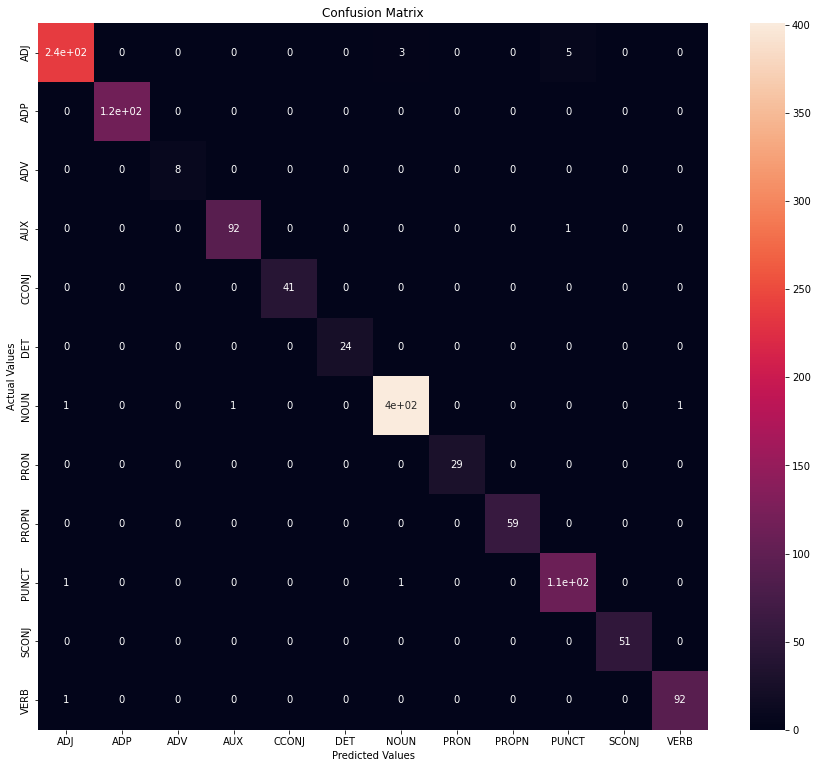

In [95]:
classes = np.union1d(np.unique(actual), np.unique(predicted))
cm = metrics.confusion_matrix(actual, predicted)
cm_df = pd.DataFrame(cm,
                     index = classes,
                     columns = classes)
#Plotting the confusion matrix
plt.figure(figsize=(15,13))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [92]:
sentence = Sentence('Srbija je tokom bombardovanja devedesetih izgubila mnoge kulturne znamenitosti.')

# predict tags and print
model.predict(sentence)

print(sentence.to_tagged_string())

Sentence: "Srbija je tokom bombardovanja devedesetih izgubila mnoge kulturne znamenitosti ." → ["Srbija"/PROPN, "je"/AUX, "tokom"/ADJ, "bombardovanja"/NOUN, "devedesetih"/ADJ, "izgubila"/NOUN, "mnoge"/NOUN, "kulturne"/ADJ, "znamenitosti"/NOUN, "."/PUNCT]
